## Determining an Unknown Players Basketball Position Using K-Nearest Neighbor Classification 

### Tegvir Multani, Marcus Lam, Joel Jacob, Elaina Qiu

### Intro
In the game of basketball, there are five positions or roles that players play: Point Guard (PG), Shooting Guard (SG), Small Forward (SF), Power Forward (PF), and Center (C)
With our project, we aim to classify a given unknown player into one of these five positions using the K-Nearest Neighbor classification algorithm. 
We are using the official player statistics from the 2022-2023 NBA season as our dataset as it’s the most popular league and updated player stats. 
The dataset contains the names of all the players that played in the 2022-2023 NBA season along with their identifying information (team, age, position), and player statistics (points, rebounds, assists, blocks, steals, turnovers and shooting percentage). 



#### Preliminary Exploratory Data Analysis & Methods

In order to predict an unknown basketball player’s position, we will use position (POS) as an explanatory variable, with free throw attempts per game (FTA), total rebounds per game (TRB), steals per game (STL), assists per game (AST), three pointers attempted (3PA),  blocks per game (BLK), turnovers per game (TOV), personal fouls per game (PF), and points per game (PTS) as predictor variables. We will use games played (GP) and minutes played (MP) variables to weed out players who have played very few games, with skewed stats. In this dataset, some players have multiple observations (rows) as they played for multiple teams in a season. We will  keep only the player’s observation for the total season across all teams. We will also run a cross validation and plot neighbors against accuracy on a point graph to find the most accurate k value to apply in our model. One way to visualize the results is by using a bar graph to visually compare differences in performance across positions for specific statistics. 

**Loading Libraries:**

In [1]:
options(warn=-1)
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

**Downloading and Reading File:**

In [2]:
download.file("https://raw.githubusercontent.com/Elalalaqqq/DSCI-100-2023W2-GROUP-28/main/data/2022-2023%20NBA%20Player%20Stats%20-%20Regular.csv", "data/nbadata.csv")
nbaStats <- read_csv2("data/nbadata.csv")
nbaStats

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Rows: 679 Columns: 30
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (25): Player, Pos, Tm, FG, FGA, FG%, 3P, 3PA, 3P%, 2P, 2PA, 2P%, eFG%, F...
dbl  (4): Rk, Age, G, GS
num  (1): MP

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,⋯,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Precious Achiuwa,C,23,TOR,55,12,207,3.6,7.3,⋯,0.702,1.8,4.1,6,0.9,0.6,0.5,1.1,1.9,9.2
2,Steven Adams,C,29,MEM,42,42,27,3.7,6.3,⋯,0.364,5.1,6.5,11.5,2.3,0.9,1.1,1.9,2.3,8.6
3,Bam Adebayo,C,25,MIA,75,75,346,8,14.9,⋯,0.806,2.5,6.7,9.2,3.2,1.2,0.8,2.5,2.8,20.4
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
537,Omer Yurtseven,C,24,MIA,9,0,92,1.8,3,⋯,0.833,0.9,1.7,2.6,0.2,0.2,0.2,0.4,1.8,4.4
538,Cody Zeller,C,30,MIA,15,2,145,2.5,3.9,⋯,0.686,1.7,2.6,4.3,0.7,0.2,0.3,0.9,2.2,6.5
539,Ivica Zubac,C,25,LAC,76,76,286,4.3,6.8,⋯,0.697,3.1,6.8,9.9,1,0.4,1.3,1.5,2.9,10.8


**Filter Stats For Minimum 50 Games Played**
- This is to ensure that players with inflated or deflated stats because they play so less won't be taken into account

In [3]:
filteredStats <- nbaStats |>
                    group_by(Player) |>
                    filter(n() == 1 | Tm == "TOT", G >= 50, !(Pos %in% c("PF-SF", "SF-SG", "SG-PG"))) |>
                    select("Player", "Pos", "FTA", "3PA", "G", "TRB":"PTS")

**Get Mean For Each Position:**

In [4]:
positionMean <- filteredStats |>
                group_by(Pos) |>
                mutate(across(where(is.character), as.numeric)) |>
                summarize(count = n(), across(everything(), mean, na.rm = TRUE)) |>
                select(-Player, -G)
positionMean

Pos,count,FTA,3PA,TRB,AST,STL,BLK,TOV,PF,PTS
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C,53,3.016981,1.488679,7.358491,1.949057,0.6188679,1.0358491,1.409434,2.526415,12.04528
PF,59,2.325424,3.101695,5.040678,1.959322,0.6322034,0.5050847,1.240678,1.972881,10.92373
PG,56,3.041071,4.641071,3.446429,4.973214,1.0214286,0.3196429,1.864286,1.921429,14.16964
SF,53,2.181132,3.901887,3.849057,1.843396,0.7226415,0.3452830,1.120755,1.933962,11.41887
SG,74,2.274324,4.587838,3.245946,2.658108,0.7770270,0.2783784,1.390541,1.831081,12.70405


**Create Mean Statistics Plot For Each Position Using pivot_longer() and facet_wrap()**

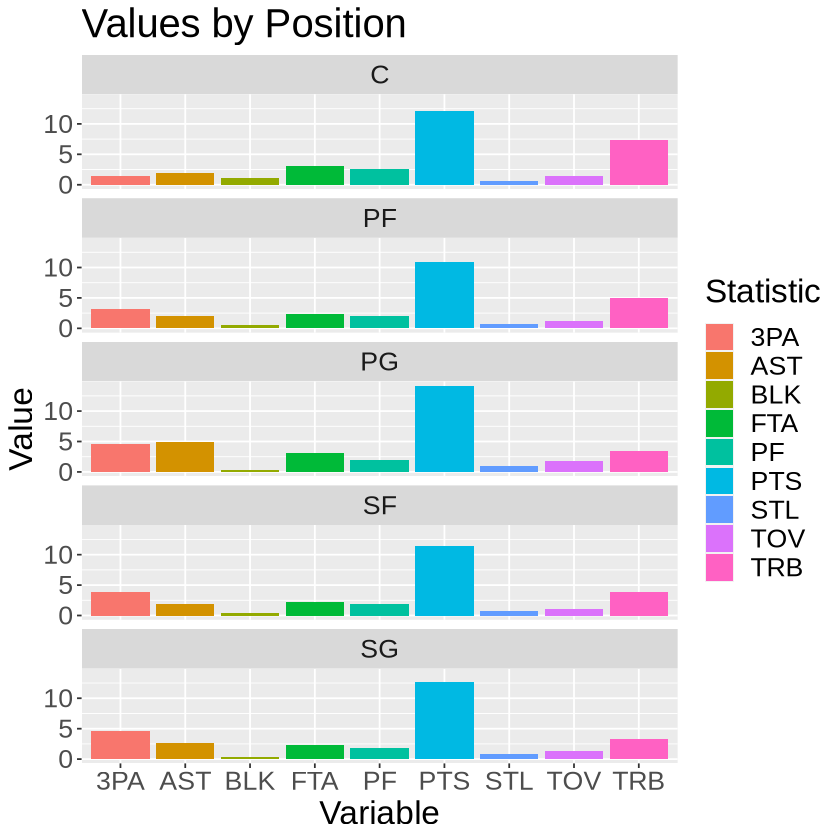

In [5]:
positionMeanLong <- positionMean |>
                    select(-count) |>
                    pivot_longer(cols = -Pos, names_to = "Variable", values_to = "Value")

positionMeanPlot <- positionMeanLong |>
                    ggplot(aes(x = Variable, y = Value, fill = Variable)) +
                    geom_bar(stat = "identity", position = "dodge") +
                    facet_wrap(~Pos, scales = "fixed", ncol = 1) +
                    labs(title = "Values by Position",
                       x = "Variable",
                       y = "Value",
                       fill = "Statistic") +
                    theme(text = element_text(size = 20))

positionMeanPlot

#### Expected Outcomes and Significance:

During this project, we expect to find a trend/pattern where certain predictor variables will have a greater of an influence on the predictor variables. For example, positions may have higher free throw percentages in games than defensive rebounds. Or, certain positions may have more free throw percentages than others. 
These findings may throw off our model as the predictor variables are weighted unequally. We will no longer have a standard deviation of 1 and an average of 0. Therefore, we will need to ensure that all of our predictor variables are centered and scaled so that the predictor variables are weighed evenly. 
Some future questions that our project could lead to is questioning if there are other predictor variables that could work and make our model more accurate, like if age should be included. It also leads us to question if this model can work on other sports as well in classifying an athlete’s unknown player position.
